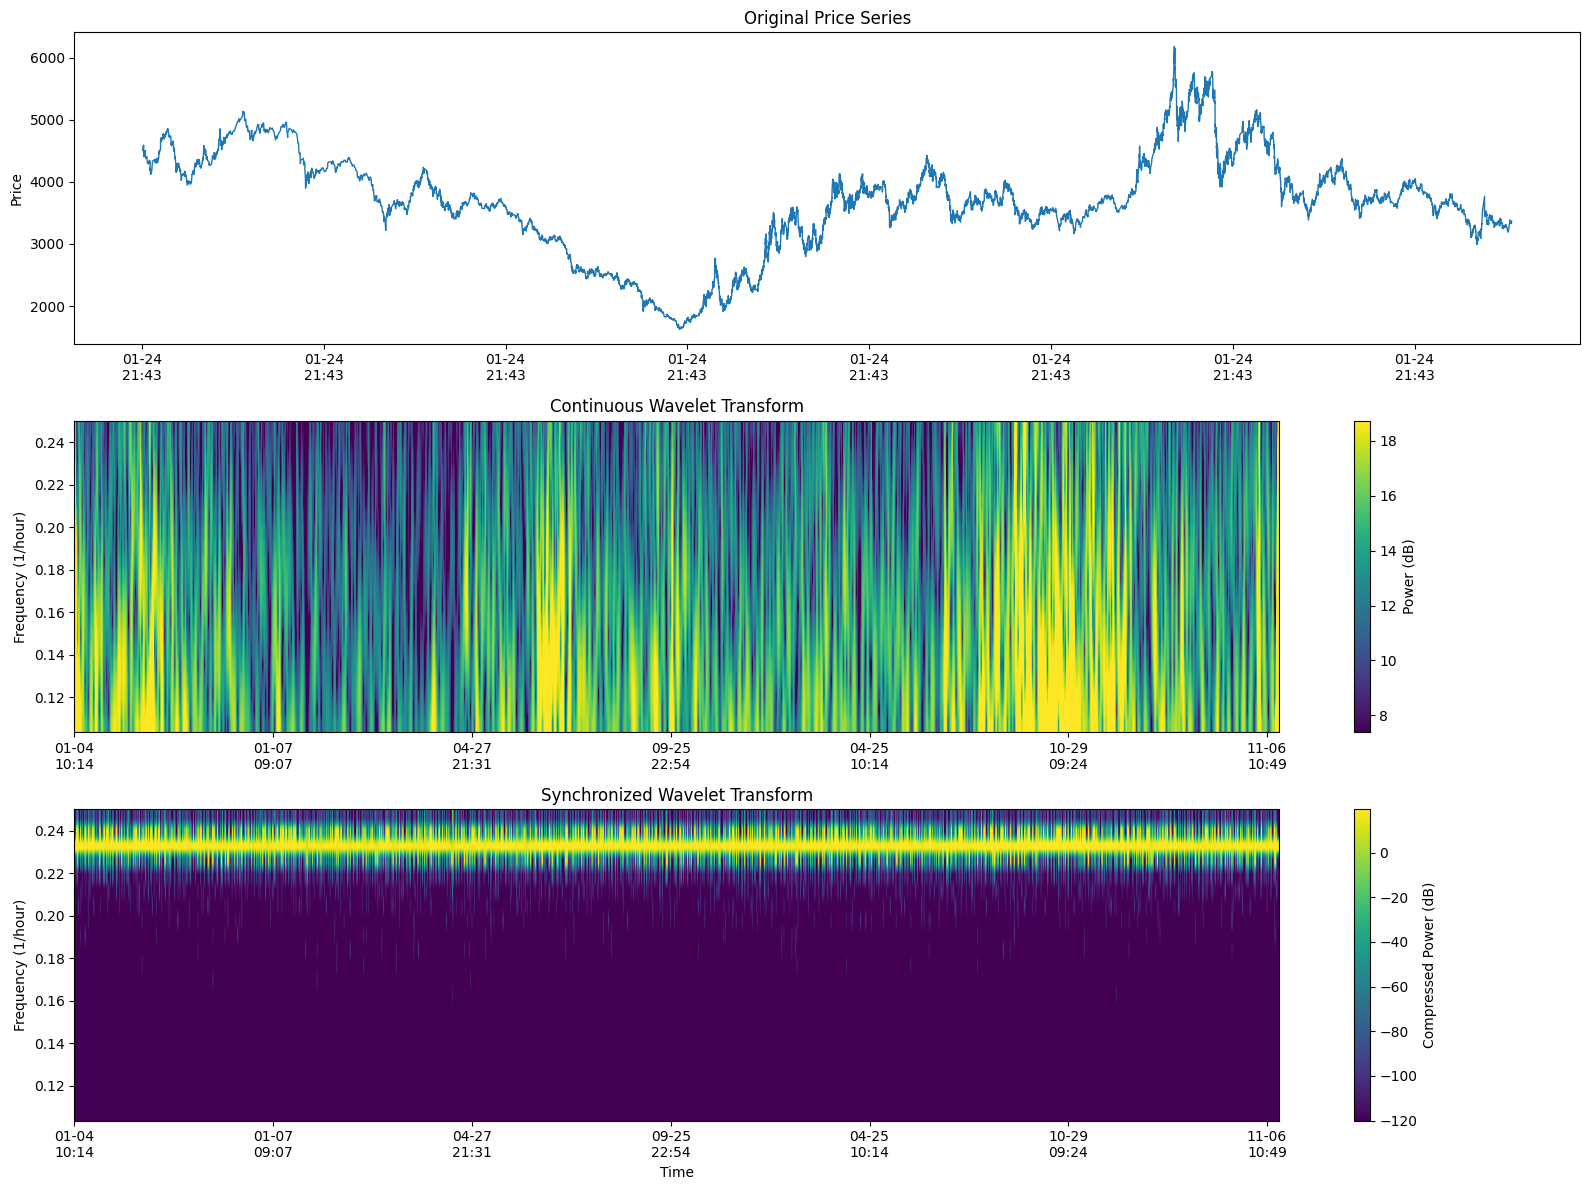

In [2]:
###   CWT（连续）+ SWT（增强型同步压缩）


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pywt

###  数据加载与预处理增强


def load_financial_data(filepath):
    df = pd.read_csv(
        filepath, parse_dates=["datetime"], infer_datetime_format=True, dayfirst=True
    )
    df = df.set_index("datetime").sort_index()

    if df["close"].isnull().sum() > 0:
        raise ValueError("数据包含空值，请预处理后再分析")
    return df


def safe_date_formatter(x, pos=None, index=pd.DatetimeIndex([])):
    try:
        dt = index[np.clip(int(np.round(x)), 0, len(index) - 1)]
        return dt.strftime("%m-%d\n%H:%M")
    except OverflowError:
        return ""


### 主流程


def time_frequency_analysis(filepath):
    df = load_financial_data(filepath)
    close_prices = df["close"].values.astype(float)
    timestamps = df.index  # 直接使用pandas的DatetimeIndex

    ###  参数
    config = {
        "wavelet": "cmor1.5-1.0",
        "sampling_hours": 0.5,
        "min_scale": 8,
        "max_scale": 128,
        "num_scales": 64,
        "dynamic_range": (5, 95),
    }

    ###  尺度参数，对数分布

    fs = 1 / config["sampling_hours"]
    scales = np.logspace(
        np.log2(config["min_scale"]),
        np.log2(config["max_scale"]),
        num=config["num_scales"],
        base=2,
    )

    ###  频率有效性验证

    scales_freq = pywt.scale2frequency(config["wavelet"], scales) * fs
    valid_scales = scales[(scales_freq > 0.1) & (scales_freq < fs / 2)]
    if len(valid_scales) < 5:
        raise ValueError("有效尺度不足，请调整参数配置")

    ###  执行连续小波变换
    cwtmat, freqs = pywt.cwt(
        close_prices,
        valid_scales,
        config["wavelet"],
        sampling_period=config["sampling_hours"],
    )

    ###  增强型同步压缩变换
    def enhanced_synchrosqueeze(cwtmat, valid_scales, dt):
        omega = (
            pywt.ContinuousWavelet(config["wavelet"]).center_frequency
            * fs
            / valid_scales[:, None]
        )
        phase = np.unwrap(np.angle(cwtmat), axis=1)
        dp = np.gradient(phase, dt, axis=1)

        rows, cols = cwtmat.shape
        k = np.round(dp * valid_scales[:, None] / (2 * np.pi)).astype(int)
        k = np.clip(k, 0, rows - 1)

        Ts = np.zeros_like(cwtmat, dtype=np.complex128)
        for j in range(cols):
            Ts[k[:, j], j] += cwtmat[:, j] * np.sqrt(valid_scales)
        return Ts

    Ts = enhanced_synchrosqueeze(cwtmat, valid_scales, config["sampling_hours"])

    fig = plt.figure(figsize=(16, 12))
    axes = [plt.subplot(3, 1, i + 1) for i in range(3)]

    ### 原始数据

    axes[0].plot(timestamps, close_prices, linewidth=1)
    axes[0].set_title("Original Price Series", fontsize=12)

    ### CWT时频谱

    cwt_dB = 10 * np.log10(np.abs(cwtmat) + 1e-12)
    im1 = axes[1].imshow(
        cwt_dB,
        extent=[
            0,
            len(timestamps) - 1,
            freqs[-1],
            freqs[0],
        ],  ###  使用索引范围替代时间戳
        aspect="auto",
        cmap="viridis",
        vmin=np.percentile(cwt_dB, config["dynamic_range"][0]),
        vmax=np.percentile(cwt_dB, config["dynamic_range"][1]),
    )
    plt.colorbar(im1, ax=axes[1], label="Power (dB)")
    axes[1].set_title("Continuous Wavelet Transform", fontsize=12)

    ###  SWT时频谱

    Ts_dB = 10 * np.log10(np.abs(Ts) + 1e-12)
    im2 = axes[2].imshow(
        Ts_dB,
        extent=[
            0,
            len(timestamps) - 1,
            freqs[-1],
            freqs[0],
        ],  ###  使用索引范围替代时间戳
        aspect="auto",
        cmap="viridis",
        vmin=np.percentile(Ts_dB, config["dynamic_range"][0]),
        vmax=np.percentile(Ts_dB, config["dynamic_range"][1]),
    )
    plt.colorbar(im2, ax=axes[2], label="Compressed Power (dB)")
    axes[2].set_title("Synchronized Wavelet Transform", fontsize=12)

    ###  统一时间轴格式化
    for ax in axes:
        ax.xaxis.set_major_formatter(
            lambda x, pos: safe_date_formatter(x, pos, index=timestamps)
        )
        ax.set_xlabel("" if ax != axes[-1] else "Time")
        ax.set_ylabel("Frequency (1/hour)" if ax != axes[0] else "Price")

    plt.tight_layout()
    plt.show()

    return None


### 数据文件，时间轴或自定义轴

time_frequency_analysis("RB99_1m_Turnover_31000_12120_591.csv")

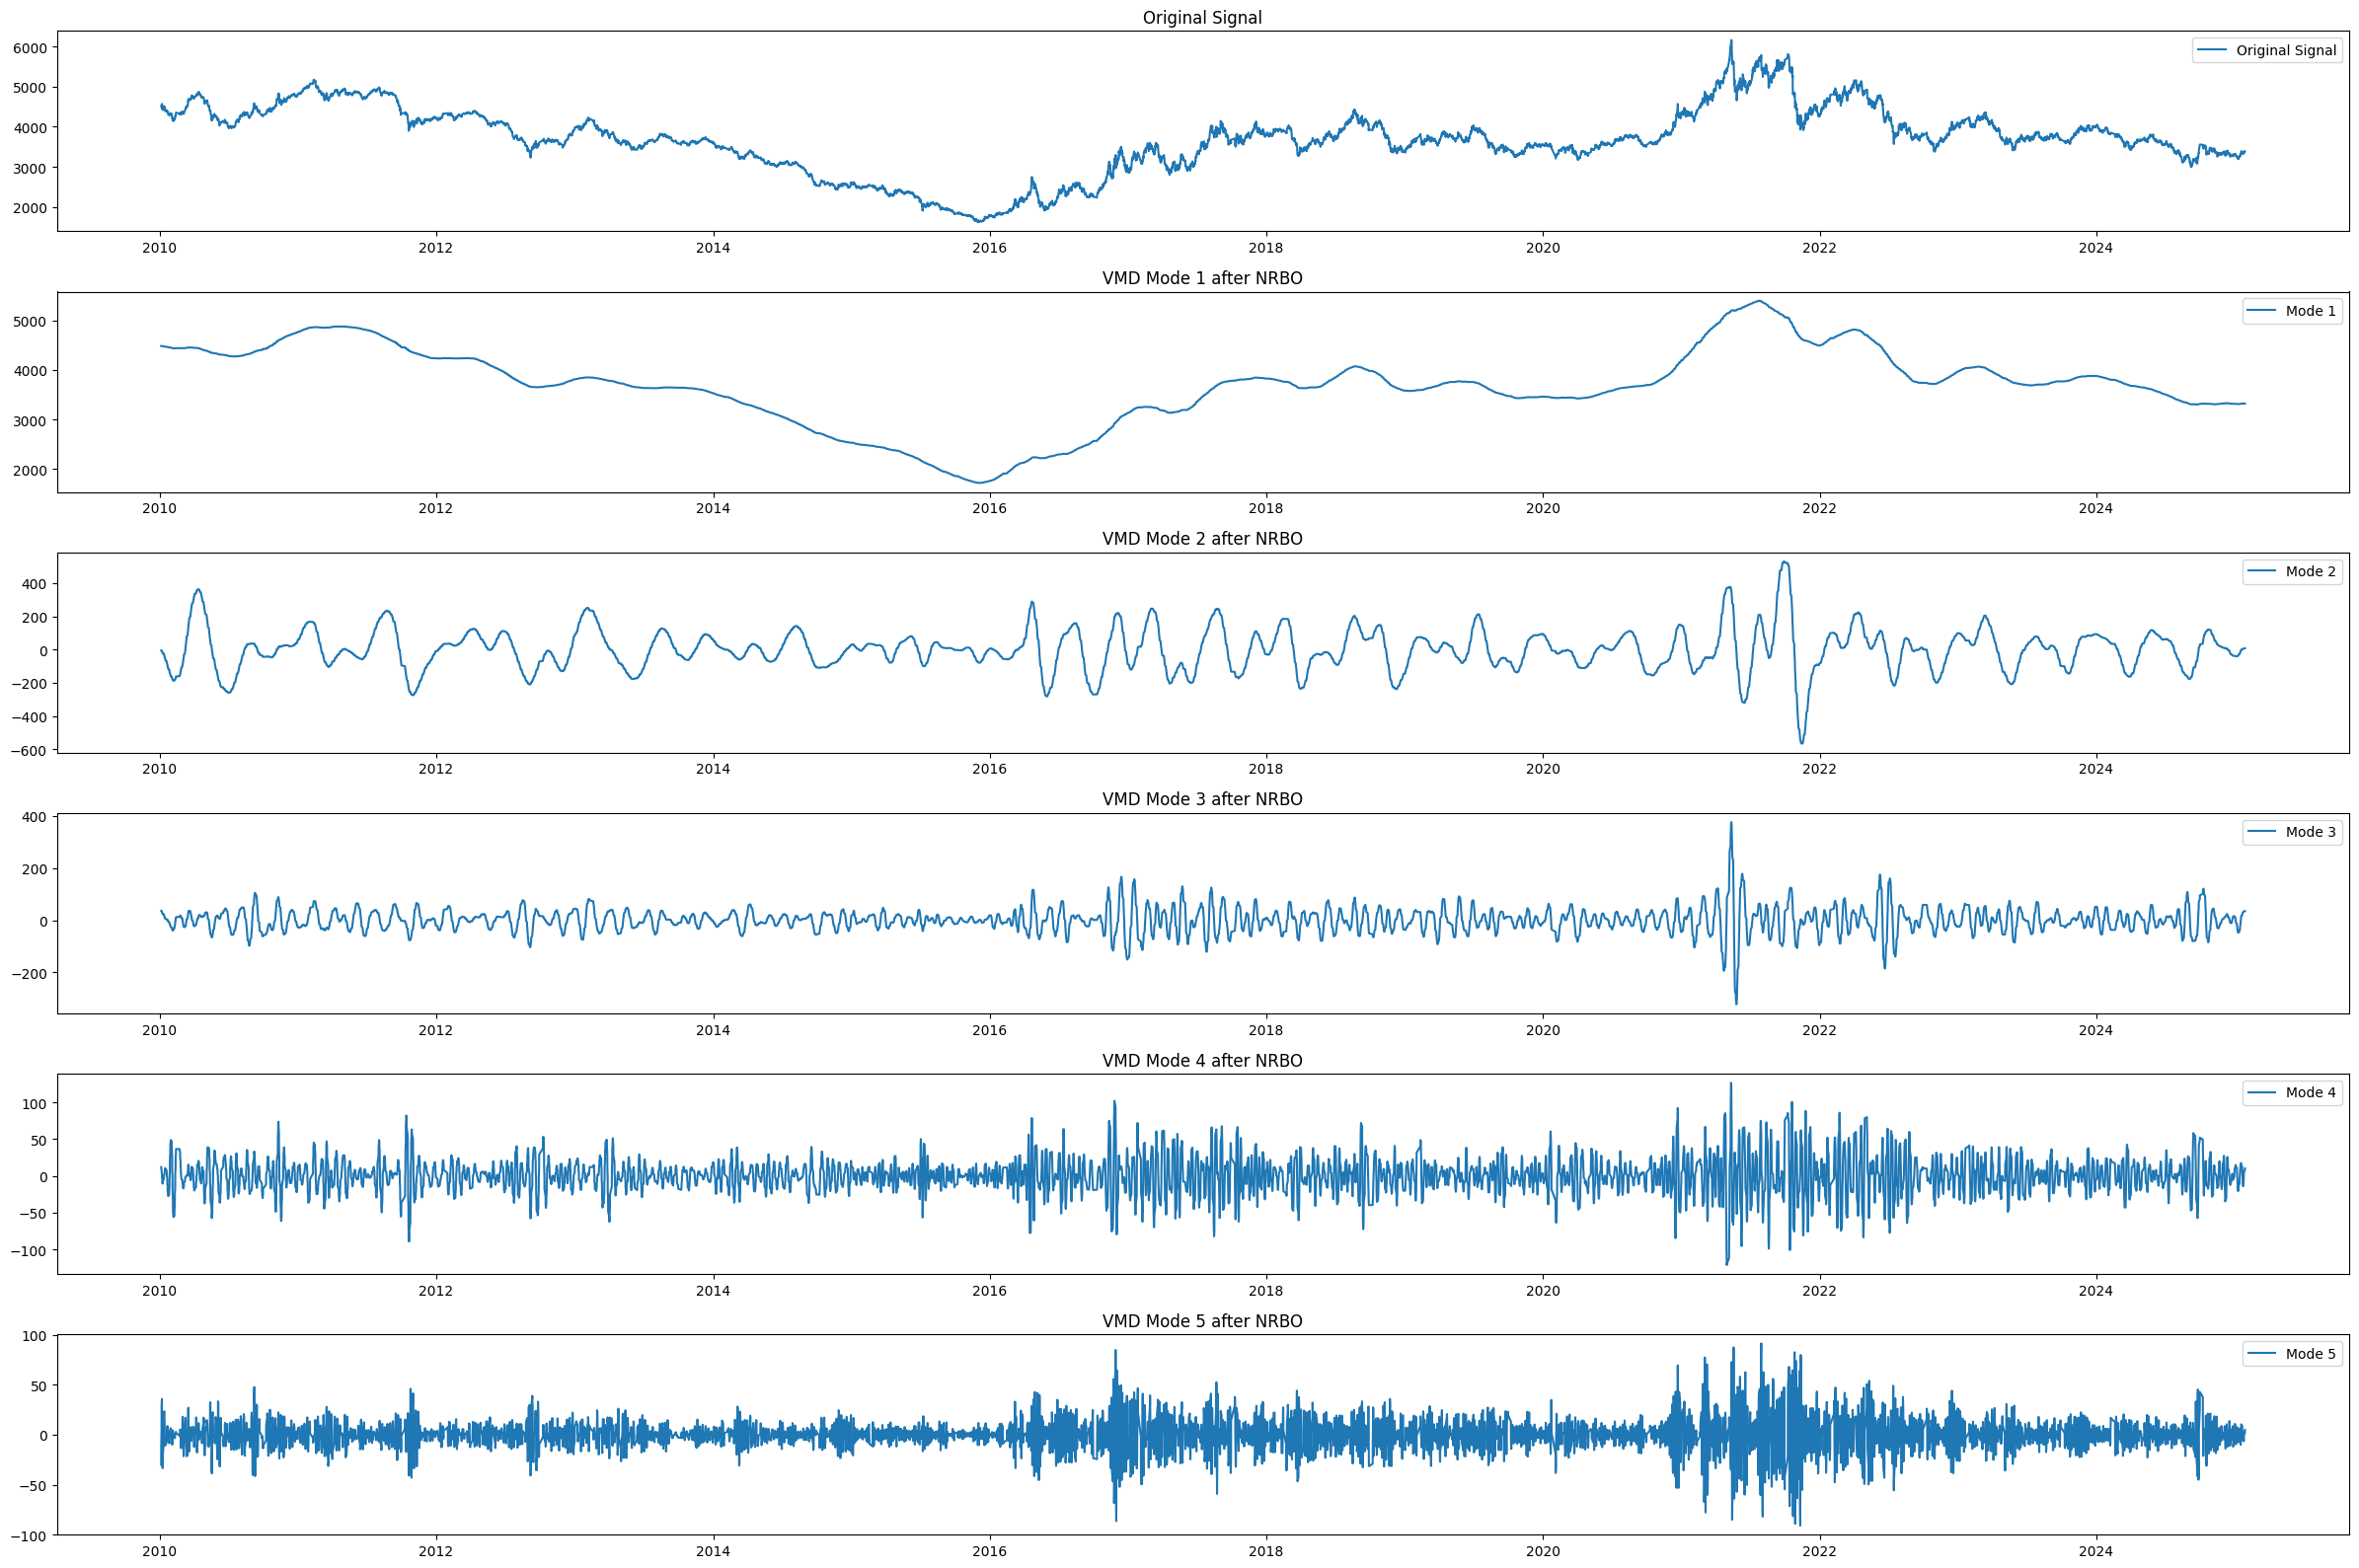

In [2]:
### VMD+NRBO频域分析

import pandas as pd
import scipy.signal as signal
from vmdpy import VMD

### NRBO


def nrbo(imf, max_iter=10, tol=1e-6):
    N = len(imf)
    for _ in range(max_iter):
        ### 计算极值点
        peaks, _ = signal.find_peaks(imf)
        valleys, _ = signal.find_peaks(-imf)
        extrema = np.sort(np.concatenate((peaks, valleys)))

        if len(extrema) < 2:
            break

        ### 计算边界点的一阶和二阶导数
        left_extrema = extrema[0]
        right_extrema = extrema[-1]

        ### 一阶导数
        df_left = (imf[left_extrema + 1] - imf[left_extrema - 1]) / 2
        df_right = (imf[right_extrema + 1] - imf[right_extrema - 1]) / 2

        ###  二阶导数
        d2f_left = imf[left_extrema + 1] - 2 * imf[left_extrema] + imf[left_extrema - 1]
        d2f_right = (
            imf[right_extrema + 1] - 2 * imf[right_extrema] + imf[right_extrema - 1]
        )

        ###  NRBO迭代更新边界点
        new_left = imf[left_extrema] - df_left / d2f_left
        new_right = imf[right_extrema] - df_right / d2f_right

        ###  判断收敛
        if (
            np.abs(new_left - imf[left_extrema]) < tol
            and np.abs(new_right - imf[right_extrema]) < tol
        ):
            break

        imf[left_extrema] = new_left
        imf[right_extrema] = new_right

    return imf


### 数据文件，时间轴或自定义轴

try:
    df = pd.read_csv(
        "RB99_120m_2010.1.1_2025.1.31.csv",
        parse_dates=["datetime"],
        index_col="datetime",
    )
    close_prices = df["close"].values.astype(float)
    timestamps = df.index
except FileNotFoundError:
    print("文件未找到，请检查文件路径。")
except Exception as e:
    print(f"读取文件时出现错误: {e}")
else:
    ### VMD参数设置

    alpha = 2000  ###  数据保真度约束
    tau = 0.0  ###  噪声容限
    K = 5  ###  模态数量
    DC = 0  ###  直流分量
    init = 1  ###  初始化中心频率
    tol = 1e-7  ### 收敛容忍度

    ###  执行VMD分解
    u, u_hat, omega = VMD(close_prices, alpha, tau, K, DC, init, tol)

    ###  应用NRBO优化
    u_nrbo = np.zeros_like(u)
    for i in range(K):
        u_nrbo[i] = nrbo(u[i])

    plt.figure(figsize=(24, 16))

    ###  原数据
    plt.subplot(K + 1, 1, 1)
    plt.plot(timestamps, close_prices, label="Original Signal")
    plt.title("Original Signal")
    plt.legend()

    ###  各个模态
    for i in range(K):
        plt.subplot(K + 1, 1, i + 2)
        plt.plot(timestamps, u_nrbo[i], label=f"Mode {i + 1}")
        plt.title(f"VMD Mode {i + 1} after NRBO")
        plt.legend()

    plt.tight_layout()
    plt.show()

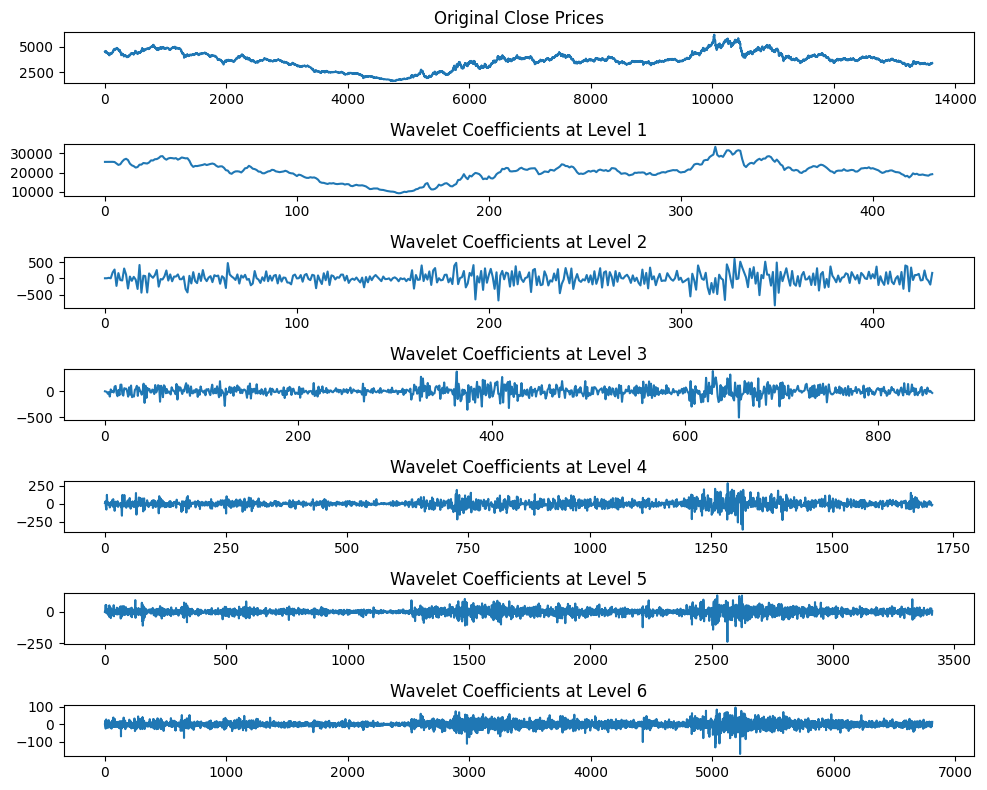

In [3]:
### 离散小波变换（小波基db4）


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### 数据文件，时间轴或自定义轴

data = pd.read_csv("RB99_120m_2010.1.1_2025.1.31.csv")

data["datetime"] = pd.to_datetime(data["datetime"])

close_prices = data["close"].values

wavelet = "db4"
coeffs = pywt.wavedec(close_prices, wavelet, level=5)

plt.figure(figsize=(10, 8))
plt.subplot(len(coeffs) + 1, 1, 1)
plt.plot(close_prices)
plt.title("Original Close Prices")

for i, c in enumerate(coeffs):
    plt.subplot(len(coeffs) + 1, 1, i + 2)
    plt.plot(c)
    plt.title(f"Wavelet Coefficients at Level {i + 1}")

plt.tight_layout()
plt.show()